# Parkinson Detection System

### Added modules

In [1]:
import logging
import os
import sys
import cv2
import numpy as np
from imutils import paths, build_montages
from skimage import feature
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
class ApplicationParameters(object):
    
    def __init__(self):
        """ Aplication parameter initialiser """
        
        # Model variable
        self.model = None
        
        # Learning parameters
        self.n_trials = 10
        self.n_estimators=100        
        
        # Store current working directory
        self.path = os.path.abspath('')
        
        # Append current directory to the python path
        sys.path.append(self.path)
        
        # Define the path to the training and testing directories        
        # Spiral
        self.spiral_training_path = self.path + '/dataset/spiral/training'
        self.spiral_testing_path = self.path + '/dataset/spiral/testing'
        
        # Wave
        self.wave_training_path = self.path + '/dataset/wave/training'
        self.wave_testing_path = self.path + '/dataset/wave/testing'

In [4]:
def quantify_image(image):
    # compute the histogram of oriented gradients feature vector for the input image
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")

    # return the feature vector
    return features

In [5]:
def load_split(path):
    # grab the list of images in the input directory, then initialises the list of data and class labels
    image_paths = list(paths.list_images(path))
    data = []
    labels = []

    # loop over the image paths
    for imagePath in image_paths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the input image, convert it to grayscale, and resize # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))

        # threshold the image such that the drawing appears as white on a black background
        image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # quantify the image
        features = quantify_image(image)

        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)

    # return the data and labels
    return np.array(data), np.array(labels)

## Spiral Test

[INFO] loading data... 

[INFO] training model 1 of 10...
[INFO] training model 2 of 10...
[INFO] training model 3 of 10...
[INFO] training model 4 of 10...
[INFO] training model 5 of 10...
[INFO] training model 6 of 10...
[INFO] training model 7 of 10...
[INFO] training model 8 of 10...
[INFO] training model 9 of 10...
[INFO] training model 10 of 10...


accuracy
u=0.8367, o=0.0277

sensitivity
u=0.7467, o=0.0499

specificity
u=0.9267, o=0.0200



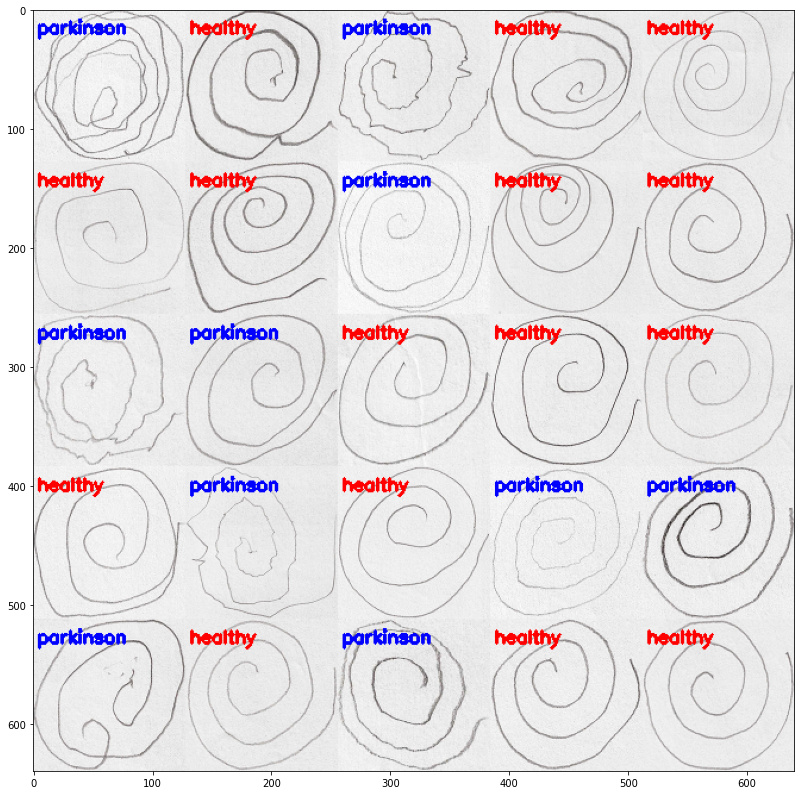

In [8]:
# Application initaliser
app = ApplicationParameters()

# loading the training and testing data
print("[INFO] loading data... \n")
(trainX, trainY) = load_split(app.spiral_training_path)
(testX, testY) = load_split(app.spiral_testing_path)

# encode the labels as integers
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

# initialise our trials dictionary
trials = {}

# loop over the number of trials to run
for i in range(0, int(app.n_trials)):
    # train the model
    print("[INFO] training model {} of {}...".format(i + 1, int(app.n_trials)))
    app.model = RandomForestClassifier(app.n_estimators)
    app.model.fit(trainX, trainY)

    # make predictions on the testing data and initialise a dictionary to store our computed metrics
    predictions = app.model.predict(testX)
    metrics = {}

    # compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity
    cm = confusion_matrix(testY, predictions).flatten()
    (tn, fp, fn, tp) = cm
    metrics["accuracy"] = (tp + tn) / float(cm.sum())
    metrics["sensitivity"] = tp / float(tp + fn)
    metrics["specificity"] = tn / float(tn + fp)

    # loop over the metrics
    for (k, v) in metrics.items():
        # update the trials dictionary with the list of values for the current metric
        l = trials.get(k, [])
        l.append(v)
        trials[k] = l

print('\n')
        
# loop over our metrics
for metric in ("accuracy", "sensitivity", "specificity"):
    # grab the list of values for the current metric, then compute the mean and standard deviation
    values = trials[metric]
    mean = np.mean(values)
    std = np.std(values)

    # show the computed metrics for the statistic
    print(metric)
    print("=" * len(metric))
    print("u={:.4f}, o={:.4f}".format(mean, std))
    print("")

# randomly select a few images and then initialise the output images for the montage
testing_paths = list(paths.list_images(app.spiral_testing_path))
idxs = np.arange(0, len(testing_paths))
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

# loop over the testing samples
for i in idxs:
    # load the testing image, clone it, and resize it
    image = cv2.imread(testing_paths[i])
    output = image.copy()
    output = cv2.resize(output, (128, 128))

    # pre-process the image in the same manner we did earlier
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # quantify the image and make predictions based on the extracted features using the last trained Random Forest
    features = quantify_image(image)
    preds = app.model.predict([features])
    label = le.inverse_transform(preds)[0]

    # draw the colored class label on the output image and add it to the set of output images
    color = (255, 0, 0) if label == "healthy" else (0, 0, 255)
    cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    images.append(output)

# create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

#Show the image with matplotlib
plt.figure(figsize=(14, 14))
plt.imshow(montage)
plt.show()

## Wave Test

[INFO] loading data... 

[INFO] training model 1 of 10...
[INFO] training model 2 of 10...
[INFO] training model 3 of 10...
[INFO] training model 4 of 10...
[INFO] training model 5 of 10...
[INFO] training model 6 of 10...
[INFO] training model 7 of 10...
[INFO] training model 8 of 10...
[INFO] training model 9 of 10...
[INFO] training model 10 of 10...


accuracy
u=0.7167, o=0.0428

sensitivity
u=0.7067, o=0.0611

specificity
u=0.7267, o=0.0629



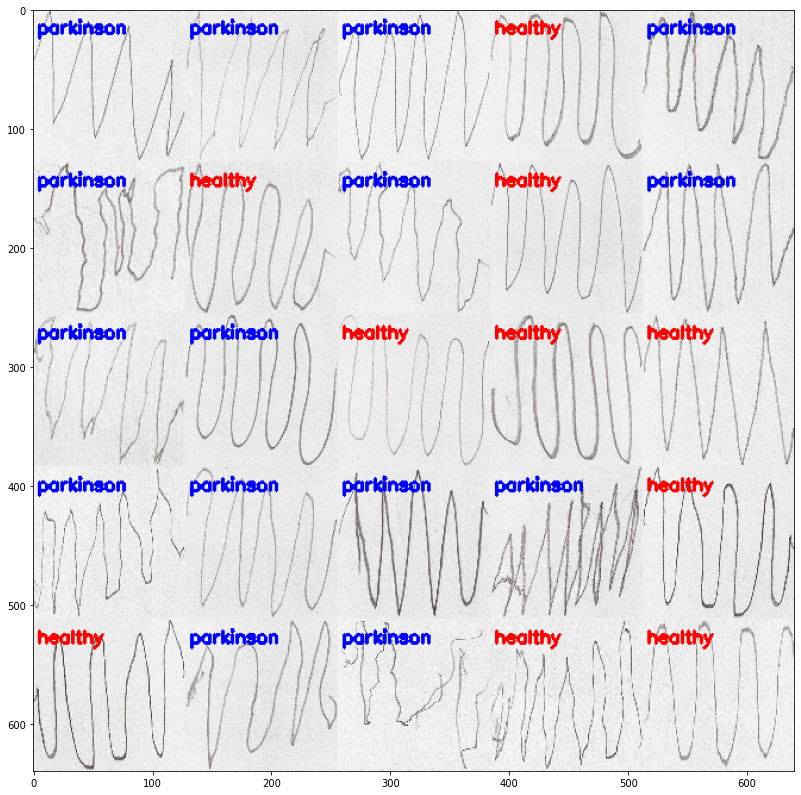

In [7]:
# Application initaliser
app = ApplicationParameters()

# loading the training and testing data
print("[INFO] loading data... \n")
(trainX, trainY) = load_split(app.wave_training_path)
(testX, testY) = load_split(app.wave_testing_path)

# encode the labels as integers
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

# initialise our trials dictionary
trials = {}

# loop over the number of trials to run
for i in range(0, int(app.n_trials)):
    # train the model
    print("[INFO] training model {} of {}...".format(i + 1, int(app.n_trials)))
    app.model = RandomForestClassifier(app.n_estimators)
    app.model.fit(trainX, trainY)

    # make predictions on the testing data and initialise a dictionary to store our computed metrics
    predictions = app.model.predict(testX)
    metrics = {}

    # compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity
    cm = confusion_matrix(testY, predictions).flatten()
    (tn, fp, fn, tp) = cm
    metrics["accuracy"] = (tp + tn) / float(cm.sum())
    metrics["sensitivity"] = tp / float(tp + fn)
    metrics["specificity"] = tn / float(tn + fp)

    # loop over the metrics
    for (k, v) in metrics.items():
        # update the trials dictionary with the list of values for the current metric
        l = trials.get(k, [])
        l.append(v)
        trials[k] = l

print('\n')
        
# loop over our metrics
for metric in ("accuracy", "sensitivity", "specificity"):
    # grab the list of values for the current metric, then compute the mean and standard deviation
    values = trials[metric]
    mean = np.mean(values)
    std = np.std(values)

    # show the computed metrics for the statistic
    print(metric)
    print("=" * len(metric))
    print("u={:.4f}, o={:.4f}".format(mean, std))
    print("")

# randomly select a few images and then initialise the output images for the montage
testing_paths = list(paths.list_images(app.wave_testing_path))
idxs = np.arange(0, len(testing_paths))
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

# loop over the testing samples
for i in idxs:
    # load the testing image, clone it, and resize it
    image = cv2.imread(testing_paths[i])
    output = image.copy()
    output = cv2.resize(output, (128, 128))

    # pre-process the image in the same manner we did earlier
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # quantify the image and make predictions based on the extracted features using the last trained Random Forest
    features = quantify_image(image)
    preds = app.model.predict([features])
    label = le.inverse_transform(preds)[0]

    # draw the colored class label on the output image and add it to the set of output images
    color = (255, 0, 0) if label == "healthy" else (0, 0, 255)
    cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    images.append(output)

# create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

#Show the image with matplotlib
plt.figure(figsize=(14, 14))
plt.imshow(montage)
plt.show()